In [1]:
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling, plotDistanceToUpstreamKinase
from msresist.figures.figure1 import plot_phenotype_heatmap
from msresist.figures.figure2 import plotCenters_together, ComputeCenters
from msresist.pca import plotPCA
from msresist.pre_processing import preprocessing
from msresist.clustering import DDMC
from msresist.plsr import plotStripActualVsPred, plotScoresLoadings
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)

In [5]:
c

,Treatment,Island
Mutant,,
KD,ae,3.900568
KD,e,3.130709
KD,ut,1.069389
KIN,ae,1.794788
KIN,e,2.472251
KIN,ut,1.233151
KO,ae,2.965147
KO,e,2.861246
KO,ut,1.217392


In [4]:
y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

,Viability,Apoptosis,Migration,Island
Lines,,,,
WT,-0.208371,0.130054,-0.027686,-0.431701
KO,-1.186327,1.638908,-1.443968,-0.483639
KD,-0.945429,0.507669,-1.774300,0.863908
KI,-0.523357,0.281607,-0.080186,1.940950
Y634F,-0.641293,0.034040,-0.244996,-0.119054
Y643F,-0.597937,0.613719,0.327549,-0.356083
Y698F,-0.343488,0.127568,0.516946,-0.514497
Y726F,-0.437530,-0.085242,0.309504,-0.306164
Y750F,-0.413532,-0.075235,-0.408378,0.775350


No handles with labels found to put in legend.


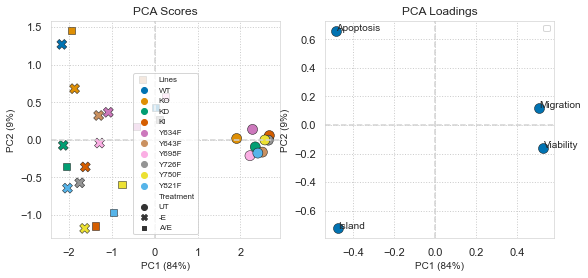

In [5]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))
plotPCA(ax, y, 2, ["Lines", "Treatment"], "Phenotype", hue_scores="Lines", style_scores="Treatment", legendOut=False)
plt.savefig("pheno_pca.svg")

In [4]:
y

NameError: name 'y' is not defined

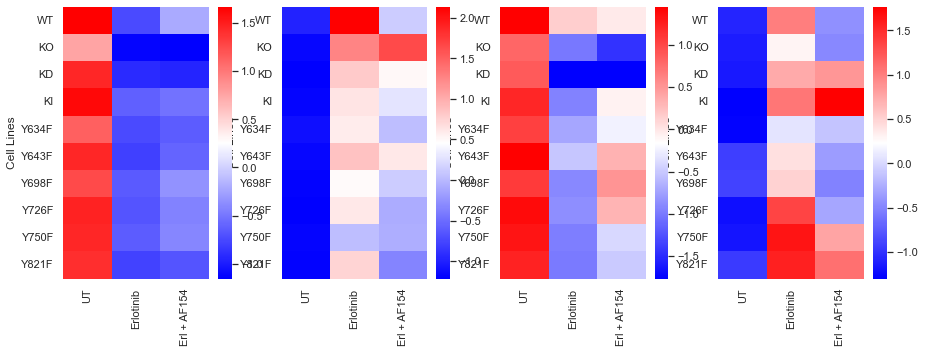

In [5]:
_, ax = plt.subplots(1, 4, figsize=(15, 5))
plot_phenotype_heatmap(ax[0], y[["Lines", "Treatment", "Viability"]])
plot_phenotype_heatmap(ax[1], y[["Lines", "Treatment", "Apoptosis"]])
plot_phenotype_heatmap(ax[2], y[["Lines", "Treatment", "Migration"]])
plot_phenotype_heatmap(ax[3], y[["Lines", "Treatment", "Island"]])

In [145]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

In [5]:
y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

,Viability,Apoptosis,Migration,Island
Lines,,,,
WT,-0.208371,0.130054,-0.027686,-0.431701
KO,-1.186327,1.638908,-1.443968,-0.483639
KD,-0.945429,0.507669,-1.774300,1.940950
KI,-0.523357,0.281607,-0.080186,0.863908
Y634F,-0.641293,0.034040,-0.244996,-0.119054
Y643F,-0.597937,0.613719,0.327549,-0.356083
Y698F,-0.343488,0.127568,0.516946,-0.514497
Y726F,-0.437530,-0.085242,0.309504,-0.306164
Y750F,-0.413532,-0.075235,-0.408378,0.775350


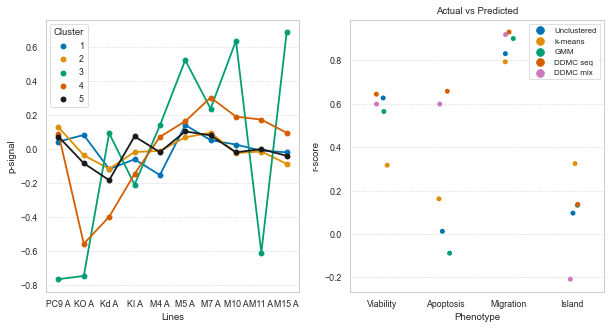

In [158]:
# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=1).fit(d)
centers = ddmc.transform()

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotCenters_together(ddmc, X, ax[0])

Xs, models = ComputeCenters(X, d, i, ddmc, 5)
Xs.append(centers)
models.append("DDMC mix")

plotStripActualVsPred(ax[1], [3, 4, 2, 3, 4], Xs, y, models)

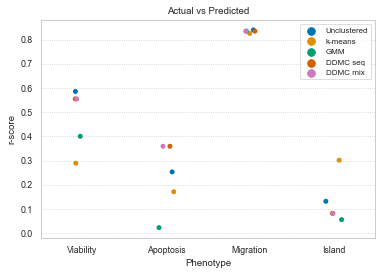

In [151]:
# Predictions
Xs, models = ComputeCenters(X, d, i, ddmc, 5)
Xs.append(centers)
models.append("DDMC mix")

_, ax = plt.subplots(1, 1)
plotStripActualVsPred(ax, [4, 4, 4, 4, 4], Xs, y, models)

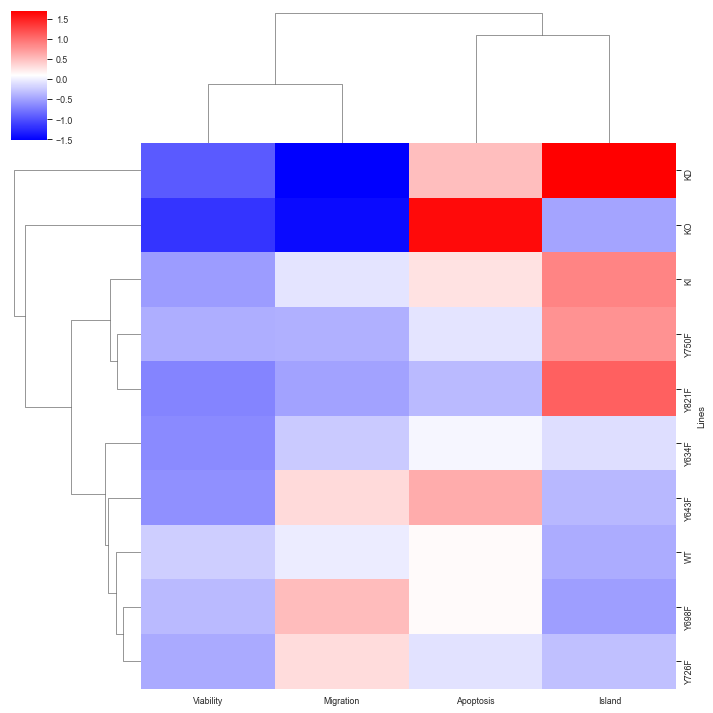

In [21]:
sns.clustermap(y, robust=True, cmap="bwr")

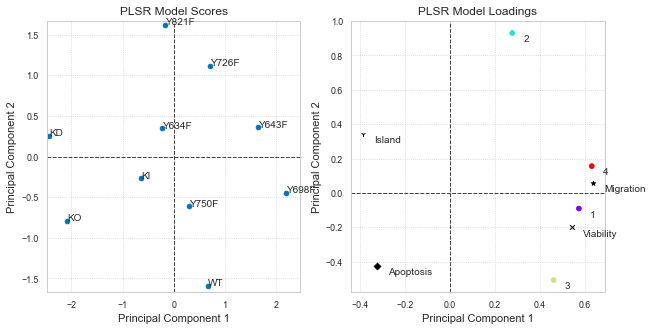

In [148]:
# Scores & Loadings
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
plsr = PLSRegression(n_components=4)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ddmc.n_components, lines, pcX=1, pcY=2)

In [ ]:
# Plot upstream kinases heatmap
plotDistanceToUpstreamKinase(ddmc, [1, 2, 3, 4, 5], ax[7], num_hits=10)